## **06 LIVE FINE TUNNING - REAL TWEETS**
## José Eduardo Viveros Escamilla | A01710605

Objetivo:

* Ajustar el modelo ya fine-tuneado en la versión moderna (V2) usando tweets 100% recientes y reales.
* Mejorar la sensibilidad del modelo hacia lenguaje actual, sarcasmo moderno, memes y variaciones lingüísticas vivas.

Acciones principales:

* Carga del modelo actualizado deeptweet_v2_modern.h5.
* Carga del dataset v3_realtweets ya procesado.
* Congelación rigurosa de capas profundas para evitar olvidado catastrófico.
* Pequeño ajuste de las últimas capas con learning rate ultra bajo (1e-5 – 5e-6).
* Entrenamiento ligero para maximizar adaptación sin perder estabilidad.
* Evaluación final comparando desempeño del modelo en:
* Tweets base de 2009
* Tweets modernos (TweetEval)
* Tweets reales capturados

Resultado producido:

* Modelo final deeptweet_v3_realtime.h5
* Este es el modelo más actualizado del proyecto, entrenado en tres generaciones del lenguaje.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

In [2]:
DATA_DIR = "data/processed_data/v3_realtweets/"

X_train = np.load(os.path.join(DATA_DIR, "X_train_live.npy"))
X_val   = np.load(os.path.join(DATA_DIR, "X_val_live.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "X_test_live.npy"))

y_train = np.load(os.path.join(DATA_DIR, "y_train_live.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val_live.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test_live.npy"))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6000, 50), (2000, 50), (2000, 50), (6000,), (2000,), (2000,))

In [ ]:
MODEL_V1_PATH = "models/deeptweet_v2_base.h5"

base_model = load_model(MODEL_V1_PATH)
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (256, 50, 150)         │     3,000,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (256, 50, 160)         │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (256, 160)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 1)               │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,153 (12.01 MB)

 Trainable params: 3,148,151 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [4]:
#for layer in base_model.layers:
#    layer.trainable = True  # entrenamos 
for layer in base_model.layers[:-4]:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [5]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="models/deeptweet_v3_modern.h5",
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6
    )
]

print("Callbacks configurados")

Callbacks configurados


In [6]:

EPOCHS = 8
BATCH_SIZE = 128

history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6054 - loss: 0.6758

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6177 - loss: 0.6662 - val_accuracy: 0.6880 - val_loss: 0.6075 - learning_rate: 1.0000e-04
Epoch 2/8
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6732 - loss: 0.6054

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6812 - loss: 0.5977 - val_accuracy: 0.7265 - val_loss: 0.5503 - learning_rate: 1.0000e-04
Epoch 3/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7344 - loss: 0.5459

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7397 - loss: 0.5365 - val_accuracy: 0.7950 - val_loss: 0.4874 - learning_rate: 1.0000e-04
Epoch 4/8
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7788 - loss: 0.4817

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7875 - loss: 0.4617 - val_accuracy: 0.8250 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 5/8
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8130 - loss: 0.4107

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8215 - loss: 0.3831 - val_accuracy: 0.8395 - val_loss: 0.3323 - learning_rate: 1.0000e-04
Epoch 6/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8237 - loss: 0.3323

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8287 - loss: 0.3241 - val_accuracy: 0.8670 - val_loss: 0.3000 - learning_rate: 1.0000e-04
Epoch 7/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8659 - loss: 0.3048

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8638 - loss: 0.3035 - val_accuracy: 0.8880 - val_loss: 0.2799 - learning_rate: 1.0000e-04
Epoch 8/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8747 - loss: 0.2883

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8727 - loss: 0.2838 - val_accuracy: 0.8875 - val_loss: 0.2596 - learning_rate: 1.0000e-04


In [12]:
test_loss, test_acc = base_model.evaluate(X_test, y_test)
print("Loss de Test:", test_loss)
print("Accuracy de Test:", test_acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8565 - loss: 0.2923
Loss de Test: 0.2923240065574646
Accuracy de Test: 0.8565000295639038


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


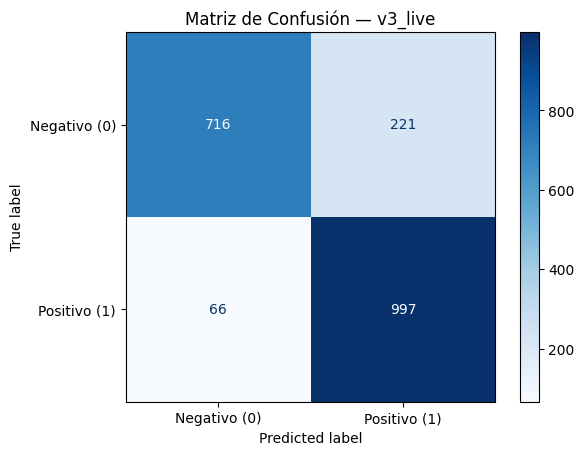

In [13]:
# ================================================================
# MATRIZ DE CONFUSIÓN — v3_live
# ================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicciones binarias
y_pred = (base_model.predict(X_test) > 0.5).astype("int32")

# Matriz
cm = confusion_matrix(y_test, y_pred)

# Mostrar matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo (0)", "Positivo (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión — v3_live")
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Predicciones
y_pred = (base_model.predict(X_test) > 0.5).astype("int32")

print("=== Classification Report — v3_live ===")
print(classification_report(y_test, y_pred, target_names=["Negativo (0)", "Positivo (1)"]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
=== Classification Report — v3_live ===
              precision    recall  f1-score   support

Negativo (0)       0.92      0.76      0.83       937
Positivo (1)       0.82      0.94      0.87      1063

    accuracy                           0.86      2000
   macro avg       0.87      0.85      0.85      2000
weighted avg       0.86      0.86      0.85      2000



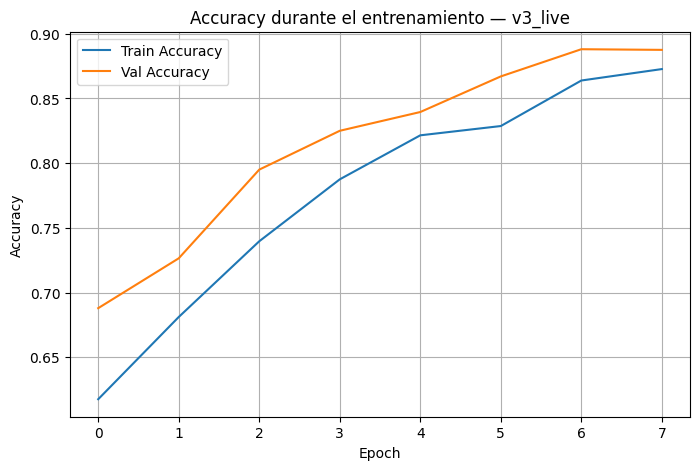

In [15]:
# ================================================================
# GRÁFICA — Accuracy
# ================================================================
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy durante el entrenamiento — v3_live")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


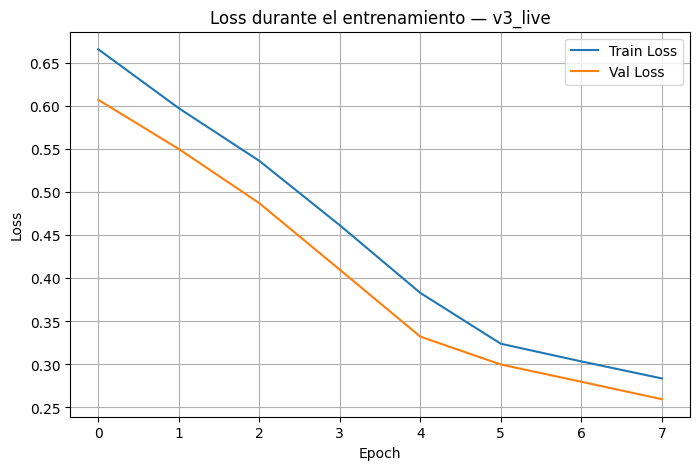

In [16]:
# ================================================================
# GRÁFICA — Pérdida (Loss)
# ================================================================
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss durante el entrenamiento — v3_live")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()